In [80]:
import os
import numpy as np 
import pandas as pd
import seaborn
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
plt.style.use('fivethirtyeight')

# Modify the background colors
plt.rcParams['figure.facecolor'] = 'white'  # Change the figure's background to white
plt.rcParams['axes.facecolor'] = 'white'    # Change the plotting area's background to white


## Collect Data

In [81]:
# Define your parameter ranges
K = [2, 4, 6, 8, 10, 12, 14, 16]
link_latency = [500]
bandwidths = list(range(0, 1100, 100))  # GB/s
chunk_size = list(range(0, 10500, 500))  # MB
chunks_per_collective = [1, 2, 3, 4]

bandwidths[0] = 1
chunk_size[0] = 1

# Generate all combinations
param_combinations = list(product(K, link_latency, bandwidths, chunk_size, chunks_per_collective))

print(f'Number of combinations: {len(param_combinations)}')

# Define the base directory where the folders are located
base_dir = 'apex_outputs'

Number of combinations: 7392


In [82]:
# Prepare a list to store the data
data = []

# Iterate over each combination
for comb in param_combinations:
    K, lat, bw, chunk, chunk_coll = comb
    folder_name = f"gpu_{K}_link_{lat}_bw_{bw}_chunk_{chunk}_chunk_coll_{chunk_coll}"
    file_name = f"gpu_{K}_link_{lat}_bw_{bw}_chunk_{chunk}_chunk_coll_{chunk_coll}_astrasim.txt"
    file_path = os.path.join(base_dir, folder_name, file_name)
    
    # Check if the file exists
    if os.path.exists(file_path):
        with open(file_path, 'r') as file:
            lines = file.readlines()
            cycles_list = []
            for line in lines:
                if "finished," in line:
                    parts = line.split(',')
                    cycles = int(parts[1].strip().split(' ')[0])
                    cycles_list.append(cycles)
                    
            # Compute statistics if cycles_list is not empty
            if cycles_list:
                max_cycles = max(cycles_list)
                mean_cycles = np.mean(cycles_list)
                median_cycles = np.median(cycles_list)
                std_dev_cycles = np.std(cycles_list)  # Standard deviation
                variance_cycles = np.var(cycles_list)  # Variance
        
                # Append the data to the list
                data.append({
                    'K': K,
                    'link_latency': lat,
                    'bandwidth': bw,
                    'chunk_size': chunk,
                    'chunks_per_collective': chunk_coll,
                    'max_runtime': max_cycles,
                    'mean_runtime': mean_cycles,
                    'median_runtime': median_cycles,
                    'std_dev_runtime': std_dev_cycles,
                    'variance_runtime': variance_cycles
                })
    else:
        print(f'Cannot find {file_path}')

# Convert the list to a DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file for further analysis
df.to_csv('runtime_analysis.csv', index=False)

print("Data extraction and compilation completed. CSV file created.")


Data extraction and compilation completed. CSV file created.


In [83]:
len(df)

7392

## Load and Prepare Data

In [84]:
# Load the data
df = pd.read_csv('runtime_analysis.csv')

# Convert data types if necessary
df['K'] = df['K'].astype(int)
df['bandwidth'] = df['bandwidth'].astype(int)
df['chunk_size'] = df['chunk_size'].astype(int)
df['chunks_per_collective'] = df['chunks_per_collective'].astype(int)

In [85]:
df

K  link_latency  bandwidth  chunk_size  chunks_per_collective  \
0      2           500          1           1                      1   
1      2           500          1           1                      2   
2      2           500          1           1                      3   
3      2           500          1           1                      4   
4      2           500          1         500                      1   
...   ..           ...        ...         ...                    ...   
7387  16           500       1000        9500                      4   
7388  16           500       1000       10000                      1   
7389  16           500       1000       10000                      2   
7390  16           500       1000       10000                      3   
7391  16           500       1000       10000                      4   

      max_runtime  mean_runtime  median_runtime  std_dev_runtime  \
0          978560  9.785600e+05        978560.0         0.000000   
1         3421467  3.177076e+06       3177076.5    244390.500000   
2         7329210  7.329210e+06       7329210.0         0.000000   
3        11724744  1.172474e+07      11724744.0         0.000000   
4          978560  9.785600e+05        978560.0         0.000000   
...           ...           ...             ...              ...   
7387      1161840  8.658880e+05        839450.0    103678.076530   
7388       308339  2.387875e+05        234901.0     25137.753279   
7389       599274  4.569991e+05        451230.0     45784.328314   
7390       929509  7.274085e+05        721021.0     68311.348624   
7391      1160295  9.237149e+05        905885.0     88995.278332   

      variance_runtime  
0         0.000000e+00  
1         5.972672e+10  
2         0.000000e+00  
3         0.000000e+00  
4         0.000000e+00  
...                ...  
7387      1.074914e+10  
7388      6.319066e+08  
7389      2.096205e+09  
7390      4.666440e+09  
7391      7.920160e+09  

[7392 rows x 10 columns]

## Descriptive Analysis

* **Mean Runtime**: Provides insights into the overall average performance of nodes within each configuration. It helps in understanding the general behavior but can be skewed by extreme values.

* **Median Runtime**: Offers a robust measure of central tendency, less affected by outliers and extreme values than the mean. This is useful to understand what a typical node's performance looks like.

* **Max Runtime**: Critical for identifying the slowest part of the network, which is the bottleneck in collective operations like All Gather. This measure is particularly important as it determines the total time to completion for synchronous operations.

### Descriptive Statistics

In [86]:
# Basic descriptive statistics
print("Descriptive Statistics:")
print(df.describe())

Descriptive Statistics:
                 K  link_latency    bandwidth    chunk_size  \
count  7392.000000        7392.0  7392.000000   7392.000000   
mean      9.000000         500.0   500.090909   5000.047619   
std       4.582886           0.0   316.105506   3027.776528   
min       2.000000         500.0     1.000000      1.000000   
25%       5.500000         500.0   200.000000   2500.000000   
50%       9.000000         500.0   500.000000   5000.000000   
75%      12.500000         500.0   800.000000   7500.000000   
max      16.000000         500.0  1000.000000  10000.000000   

       chunks_per_collective   max_runtime  mean_runtime  median_runtime  \
count             7392.00000  7.392000e+03  7.392000e+03    7.392000e+03   
mean                 2.50000  1.608699e+06  1.310026e+06    1.297166e+06   
std                  1.11811  5.370395e+06  4.379189e+06    4.335419e+06   
min                  1.00000  2.976000e+03  2.976000e+03    2.976000e+03   
25%                  1.75000

### Grouped

In [87]:
# Statistics grouped by different parameters
print("Statistics by K:")
print(df.groupby('K')['max_runtime'].describe())

Statistics by K:
    count          mean           std       min        25%       50%  \
K                                                                      
2   924.0  5.950123e+05  2.316444e+06    2976.0    7294.00   17134.5   
4   924.0  1.326011e+06  5.113962e+06   12903.0   34556.00   66874.5   
6   924.0  1.445351e+06  5.308117e+06   31270.0   74830.50  132785.5   
8   924.0  1.585617e+06  5.541858e+06   57680.0  135715.50  219050.0   
10  924.0  1.717655e+06  5.688927e+06   94165.0  214465.75  338653.5   
12  924.0  1.875021e+06  5.790049e+06  148701.0  312335.25  486345.0   
14  924.0  2.067394e+06  5.991351e+06  203814.0  434956.25  659690.0   
16  924.0  2.257532e+06  6.074977e+06  272228.0  574611.25  871008.0   

           75%         max  
K                           
2     34342.00  15632992.0  
4    110532.00  34004960.0  
6    199326.00  34227884.0  
8    319923.75  36982535.0  
10   472246.50  35642659.0  
12   668737.25  36075638.0  
14   910473.75  40014534.0  
1

In [88]:
# For mean_runtime
print("Mean Runtime Statistics by K:")
print(df.groupby('K')['mean_runtime'].describe())

Mean Runtime Statistics by K:
    count          mean           std            min            25%  \
K                                                                     
2   924.0  5.725709e+05  2.216273e+06    2976.000000    7182.000000   
4   924.0  1.129940e+06  4.361931e+06   11710.875000   29272.875000   
6   924.0  1.211463e+06  4.480160e+06   27059.444444   62085.034722   
8   924.0  1.310377e+06  4.610875e+06   48194.015625  109192.863281   
10  924.0  1.391357e+06  4.629265e+06   77055.900000  172785.480000   
12  924.0  1.495472e+06  4.655008e+06  111028.875000  248737.640625   
14  924.0  1.619854e+06  4.702519e+06  161087.836735  340656.723214   
16  924.0  1.749178e+06  4.707848e+06  207300.191406  444130.174805   

              50%            75%           max  
K                                               
2    16286.500000   33268.812500  1.441166e+07  
4    57253.156250   95173.687500  2.924977e+07  
6   111948.444444  167537.590278  3.054288e+07  
8   179869.726

In [89]:
# For median_runtime
print("Median Runtime Statistics by K:")
print(df.groupby('K')['median_runtime'].describe())

Median Runtime Statistics by K:
    count          mean           std       min         25%        50%  \
K                                                                        
2   924.0  5.770303e+05  2.238573e+06    2976.0    7206.750   16340.00   
4   924.0  1.126567e+06  4.338072e+06   11781.0   28915.375   57512.00   
6   924.0  1.212255e+06  4.492042e+06   26500.0   61448.625  111034.75   
8   924.0  1.306963e+06  4.604725e+06   47380.0  107942.750  179401.50   
10  924.0  1.377322e+06  4.584581e+06   77010.0  170141.500  269958.00   
12  924.0  1.473889e+06  4.586289e+06  109012.5  245180.125  384201.00   
14  924.0  1.591203e+06  4.611460e+06  158065.0  335236.875  513148.25   
16  924.0  1.712102e+06  4.596432e+06  204109.0  436204.125  660356.50   

           75%         max  
K                           
2    33951.625  15144461.0  
4    95959.500  29601440.0  
6   166705.000  31393728.0  
8   265984.875  30798267.5  
10  382430.250  28700054.5  
12  526459.500  28506936

### Box Plot of Runtimes

These plots allow you to quickly see the range of runtimes and the presence of outliers, which might be nodes that are consistently underperforming or encountering specific problems.

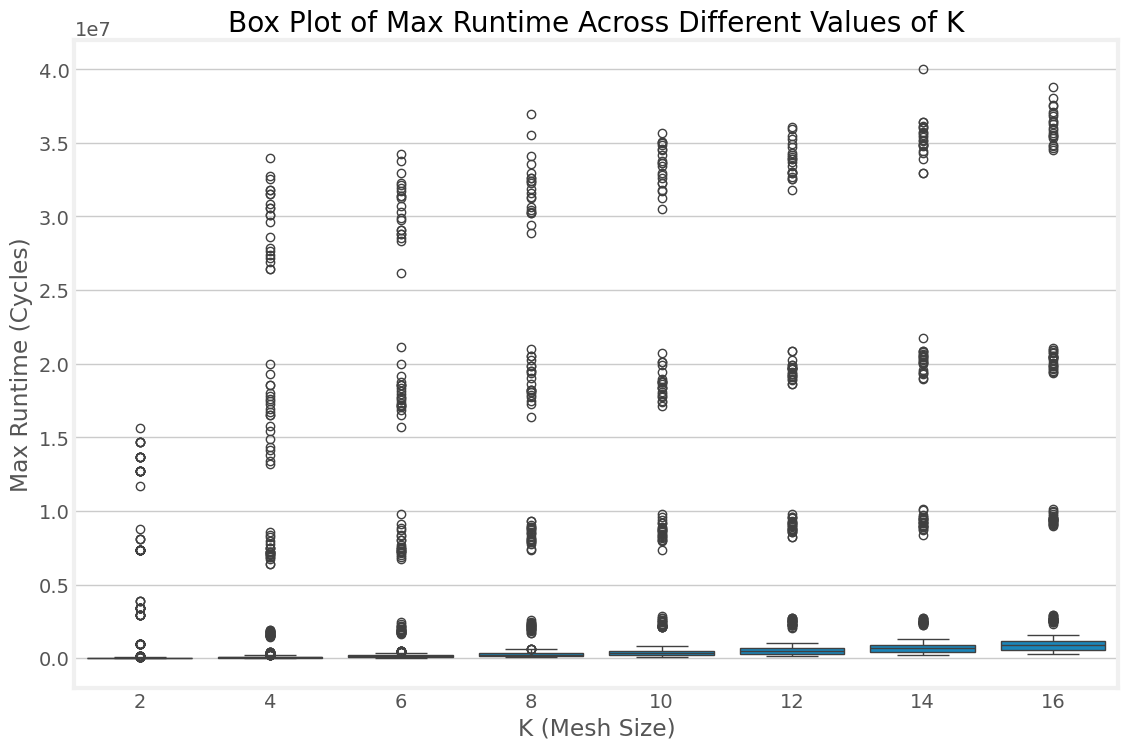

In [90]:
# Box plot for runtime across different values of K
plt.figure(figsize=(12, 8))
sns.boxplot(x='K', y='max_runtime', data=df)
plt.title('Box Plot of Max Runtime Across Different Values of K')
plt.xlabel('K (Mesh Size)')
plt.ylabel('Max Runtime (Cycles)')
plt.show()


## Distribution Analysis

### Density Plots

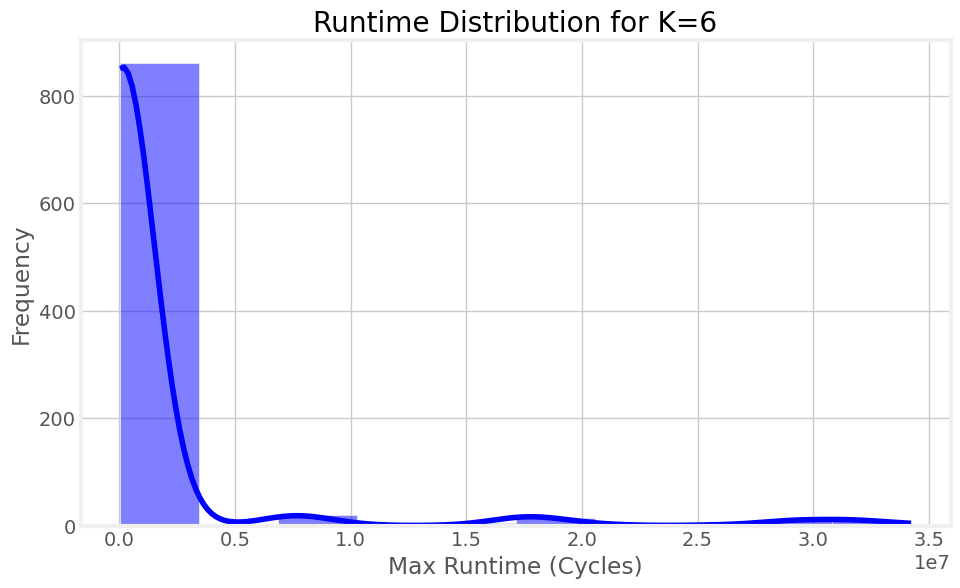

In [91]:
# Histogram and density plot for a selected parameter configuration
selected_k = 6  # Example: Analyze for K=10
subset = df[df['K'] == selected_k]

plt.figure(figsize=(10, 6))
sns.histplot(subset['max_runtime'], bins=10, kde=True, color='blue')
plt.title(f'Runtime Distribution for K={selected_k}')
plt.xlabel('Max Runtime (Cycles)')
plt.ylabel('Frequency')
plt.show()

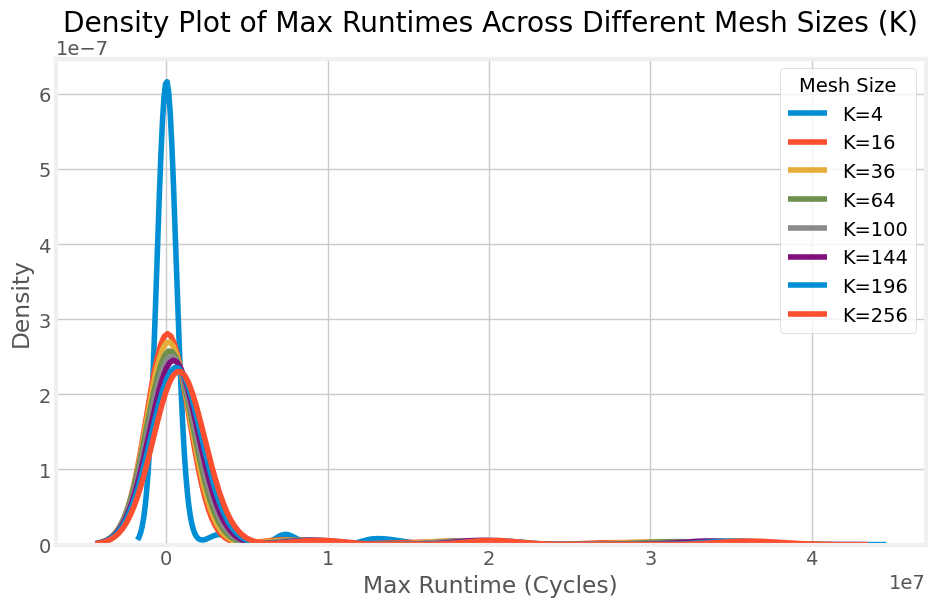

In [92]:
# Assuming 'df' is your DataFrame loaded with the appropriate data
plt.figure(figsize=(10, 6))

# Loop through unique values of K and plot a density plot for each
for k in sorted(df['K'].unique()):
    subset = df[df['K'] == k]['max_runtime']  # Adjust this if you're analyzing a different runtime metric
    sns.kdeplot(subset, label=f'K={k**2}', fill=False)

plt.title('Density Plot of Max Runtimes Across Different Mesh Sizes (K)')
plt.xlabel('Max Runtime (Cycles)')
plt.ylabel('Density')
plt.legend(title='Mesh Size')
plt.show()

### Variability

In [93]:
# Display extended descriptive statistics including variance and standard deviation
extended_stats = df.groupby('K').agg(
    mean_runtime=('mean_runtime', 'mean'),
    median_runtime=('median_runtime', 'median'),
    max_runtime=('max_runtime', 'max'),
    std_dev_runtime=('max_runtime', 'std'),
    variance_runtime=('max_runtime', 'var')
)
print("Extended Descriptive Statistics by K:")
print(extended_stats)


Extended Descriptive Statistics by K:
    mean_runtime  median_runtime  max_runtime  std_dev_runtime  \
K                                                                
2   5.725709e+05        16340.00     15632992     2.316444e+06   
4   1.129940e+06        57512.00     34004960     5.113962e+06   
6   1.211463e+06       111034.75     34227884     5.308117e+06   
8   1.310377e+06       179401.50     36982535     5.541858e+06   
10  1.391357e+06       269958.00     35642659     5.688927e+06   
12  1.495472e+06       384201.00     36075638     5.790049e+06   
14  1.619854e+06       513148.25     40014534     5.991351e+06   
16  1.749178e+06       660356.50     38811954     6.074977e+06   

    variance_runtime  
K                     
2       5.365911e+12  
4       2.615261e+13  
6       2.817610e+13  
8       3.071219e+13  
10      3.236389e+13  
12      3.352467e+13  
14      3.589629e+13  
16      3.690535e+13  


/tmp/ipykernel_390871/3925726242.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='K', y='std_dev_runtime', data=extended_stats.reset_index(), palette='viridis')


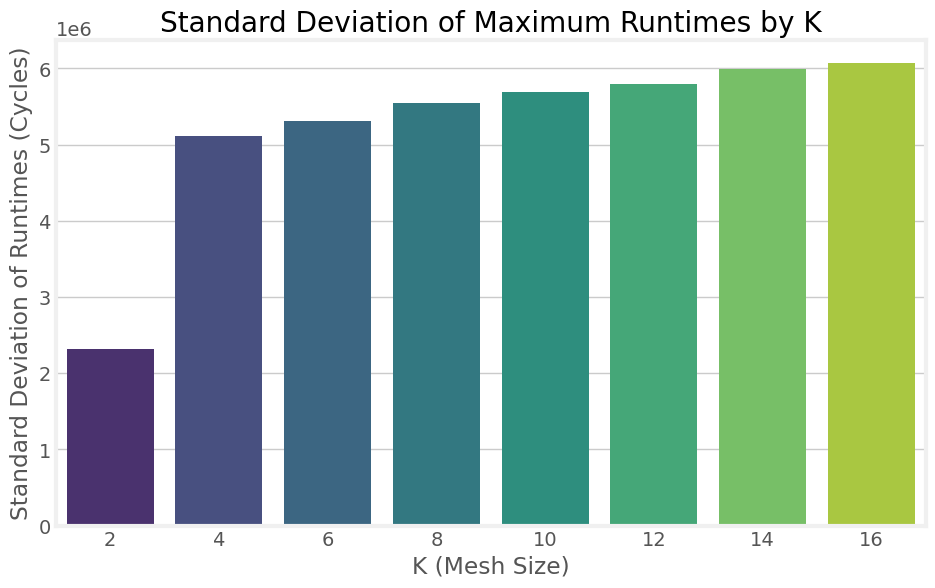

In [94]:
# Plotting standard deviation of runtimes to visualize variability
plt.figure(figsize=(10, 6))
sns.barplot(x='K', y='std_dev_runtime', data=extended_stats.reset_index(), palette='viridis')
plt.title('Standard Deviation of Maximum Runtimes by K')
plt.xlabel('K (Mesh Size)')
plt.ylabel('Standard Deviation of Runtimes (Cycles)')
plt.show()


/tmp/ipykernel_390871/1643922900.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='K', y='variance_runtime', data=extended_stats.reset_index(), palette='magma')
/tmp/ipykernel_390871/1643922900.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


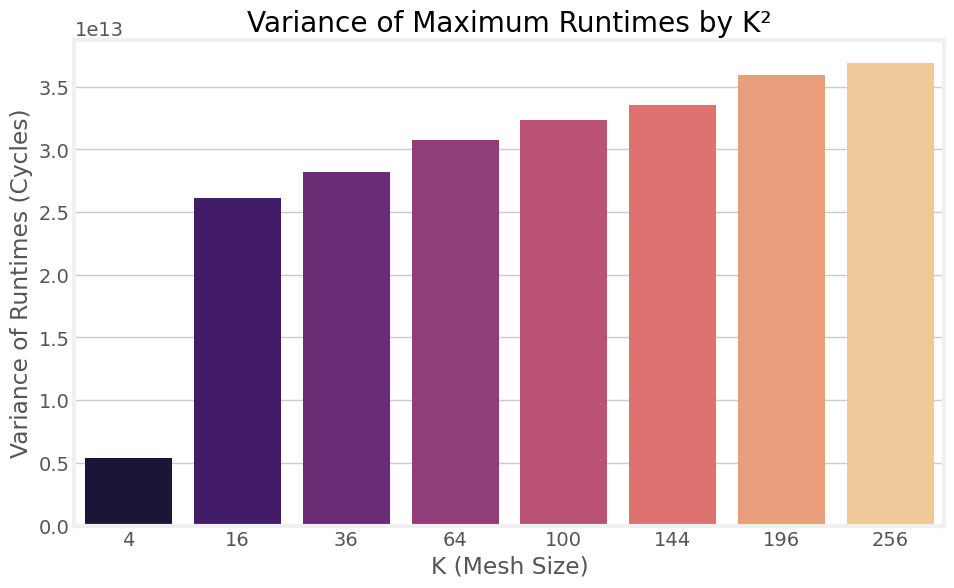

In [95]:
# Plotting variance of runtimes for a deeper look at spread
# plt.figure(figsize=(10, 6))
# sns.barplot(x='K', y='variance_runtime', data=extended_stats.reset_index(), palette='magma')
# plt.title('Variance of Maximum Runtimes by K')
# plt.xlabel('K (Mesh Size)')
# plt.ylabel('Variance of Runtimes (Cycles)')
# plt.show()

# Plotting using the original K column
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='K', y='variance_runtime', data=extended_stats.reset_index(), palette='magma')
ax.set_title('Variance of Maximum Runtimes by K²')
ax.set_xlabel('K (Mesh Size)')
ax.set_ylabel('Variance of Runtimes (Cycles)')

# Adjust x-axis labels to show K squared
labels = [str(int(label.get_text())**2) for label in ax.get_xticklabels()]
ax.set_xticklabels(labels)

plt.show()

## Trend Analysis

To perform a comprehensive trend analysis, you need to plot the changes in performance metrics (like mean, median, and maximum runtimes) across different configurations of parameters like K, bandwidth, chunk_size, and chunks_per_collective.

### Plotting Trends for Each Parameter

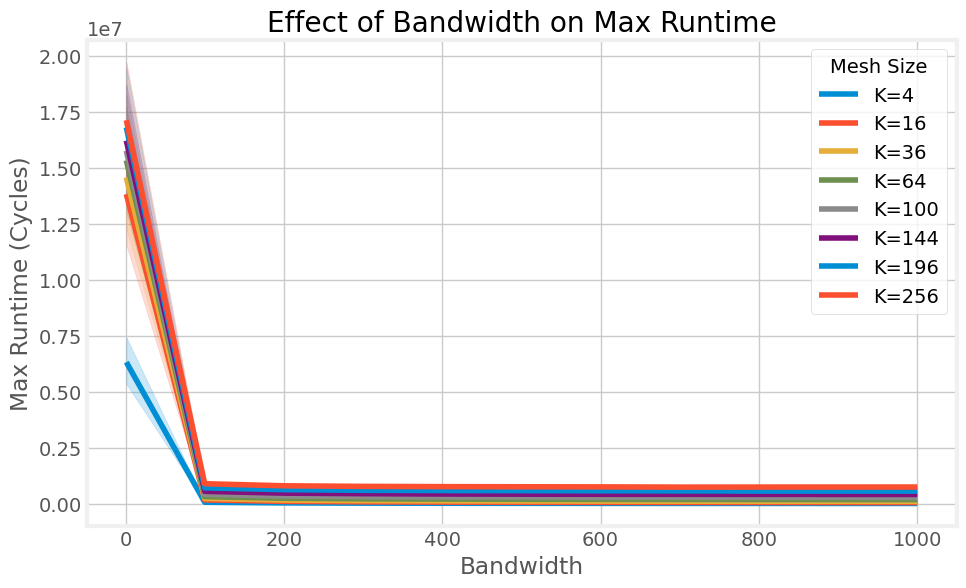

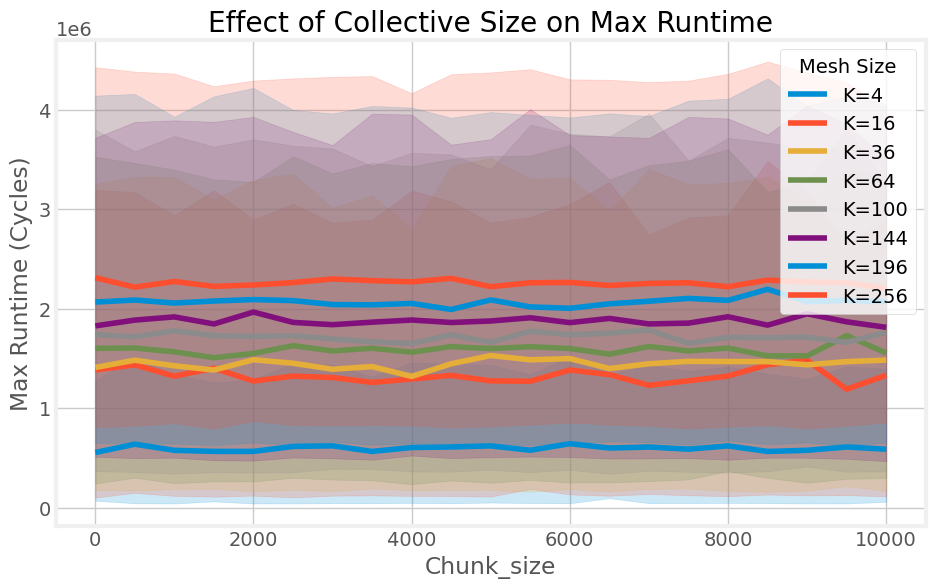

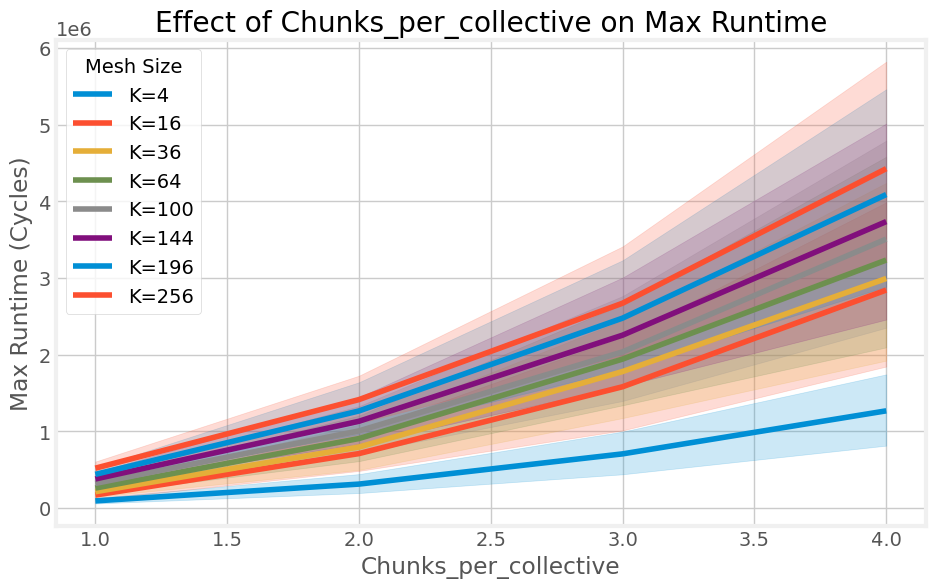

In [99]:
# Analyzing trends by plotting line graphs for different parameters
parameters = ['bandwidth', 'chunk_size', 'chunks_per_collective']
for param in parameters:
    plt.figure(figsize=(10, 6))
    for k in sorted(df['K'].unique()):
        subset = df[df['K'] == k]
        sns.lineplot(data=subset, x=param, y='max_runtime', label=f'K={k**2}')
    if param == 'chunk_size':
        plt.title(f'Effect of Collective Size on Max Runtime')
    else:
        plt.title(f'Effect of {param.capitalize()} on Max Runtime')
    plt.xlabel(param.capitalize())
    plt.ylabel('Max Runtime (Cycles)')
    plt.legend(title='Mesh Size')
    plt.show()


### Plotting Interaction Effects

To understand how combinations of parameters affect performance, you can plot interaction effects. For example, how does bandwidth interact with chunk size for different values of K?

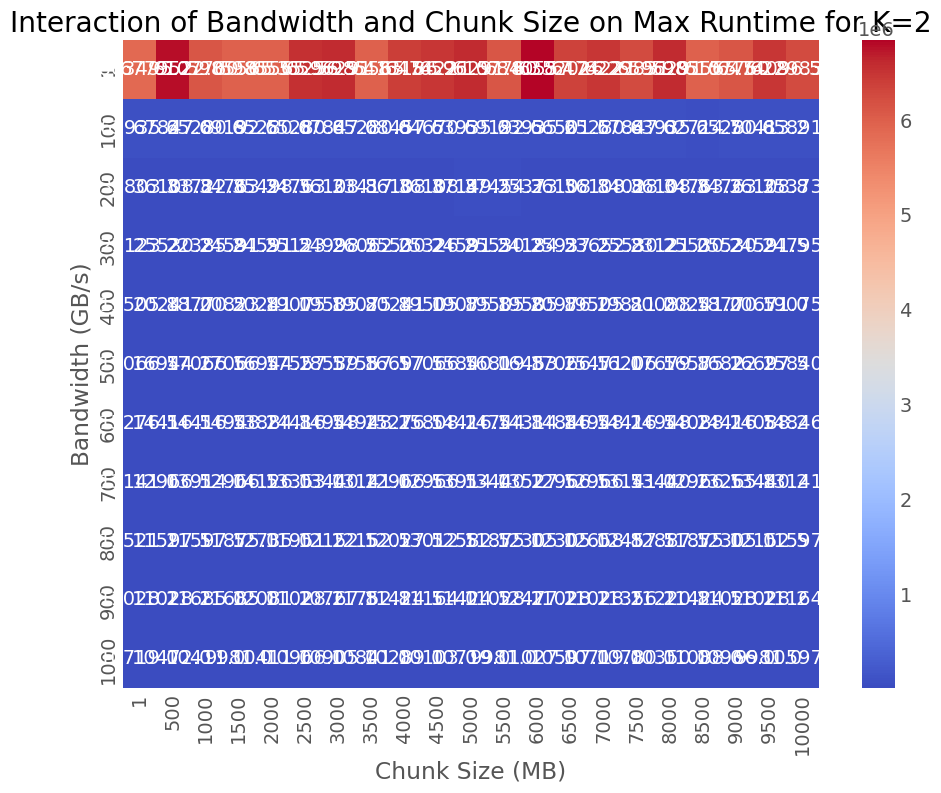

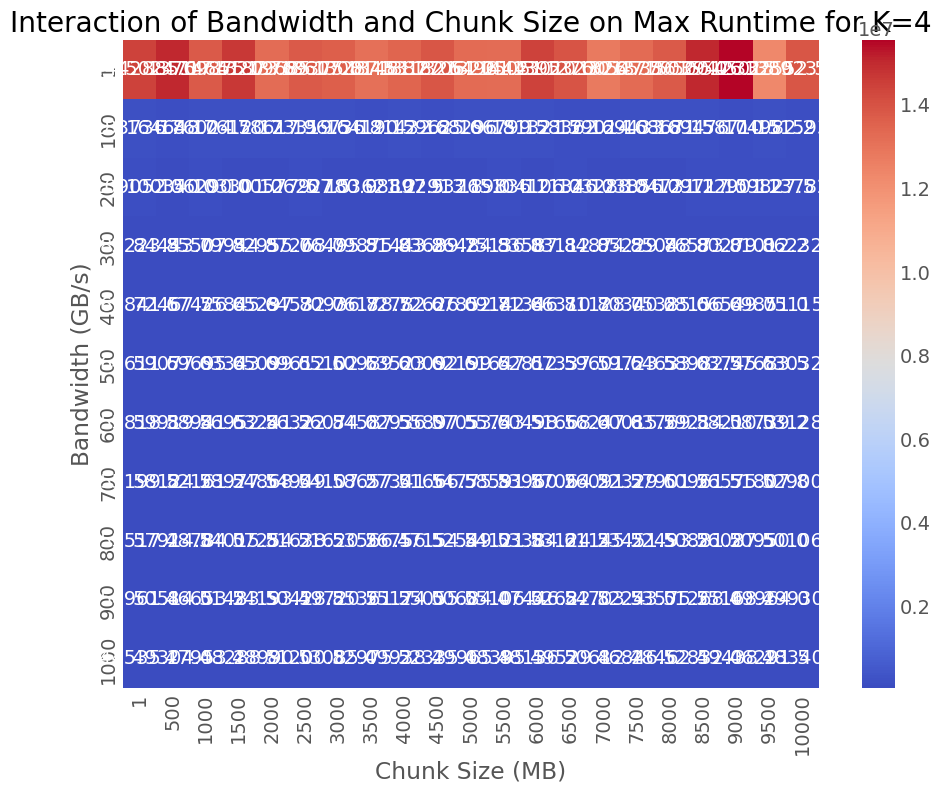

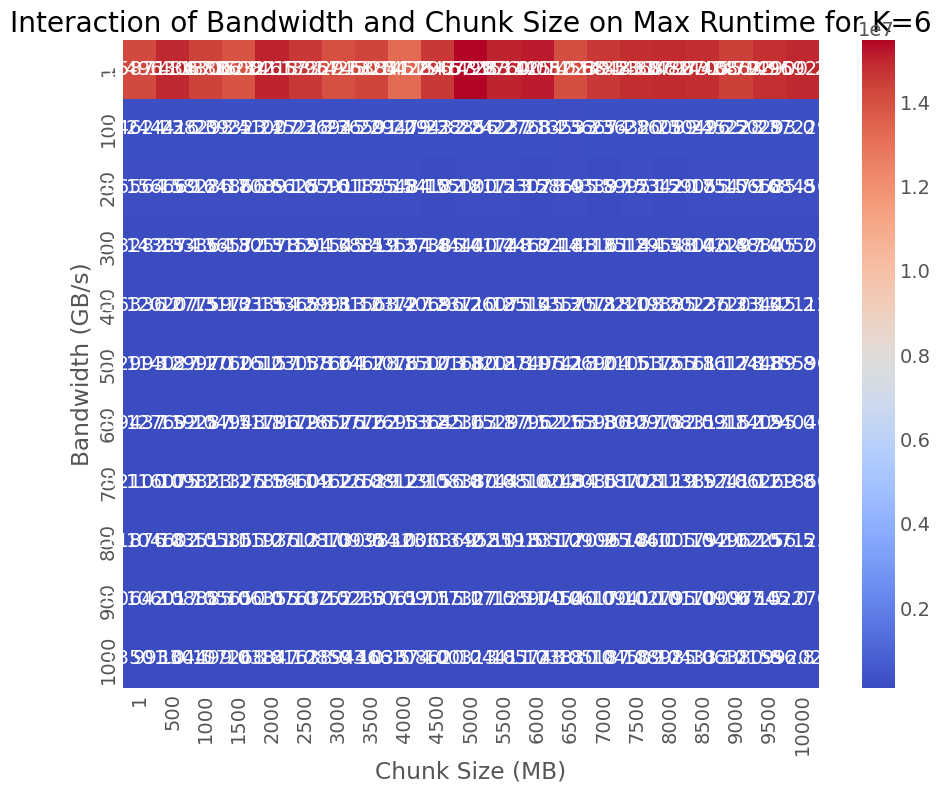

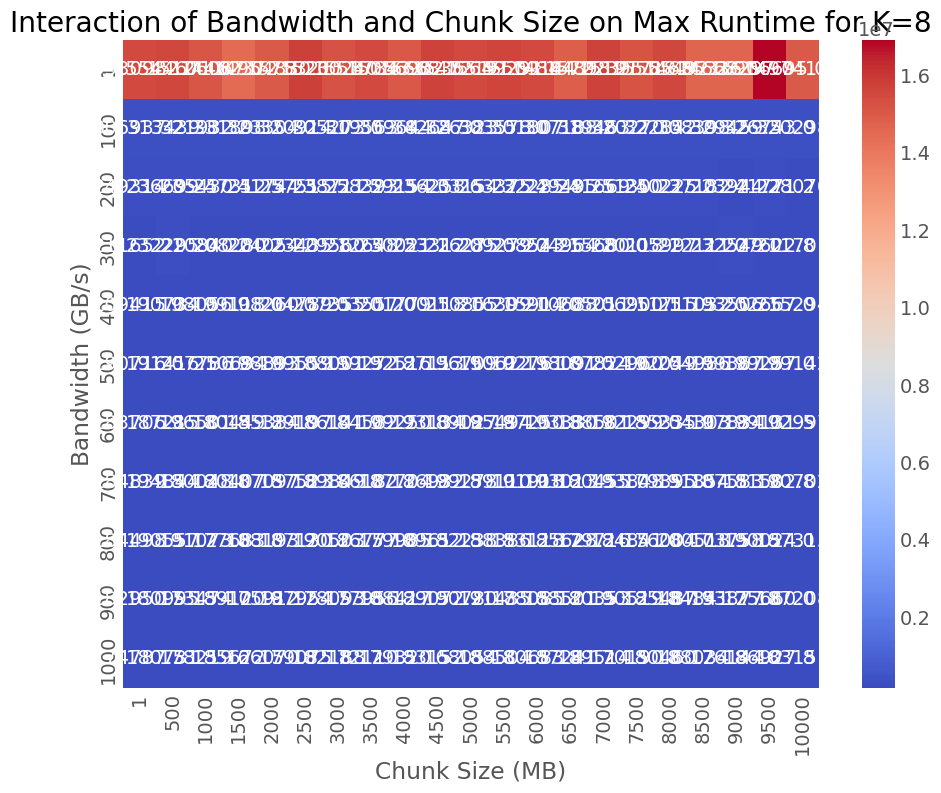

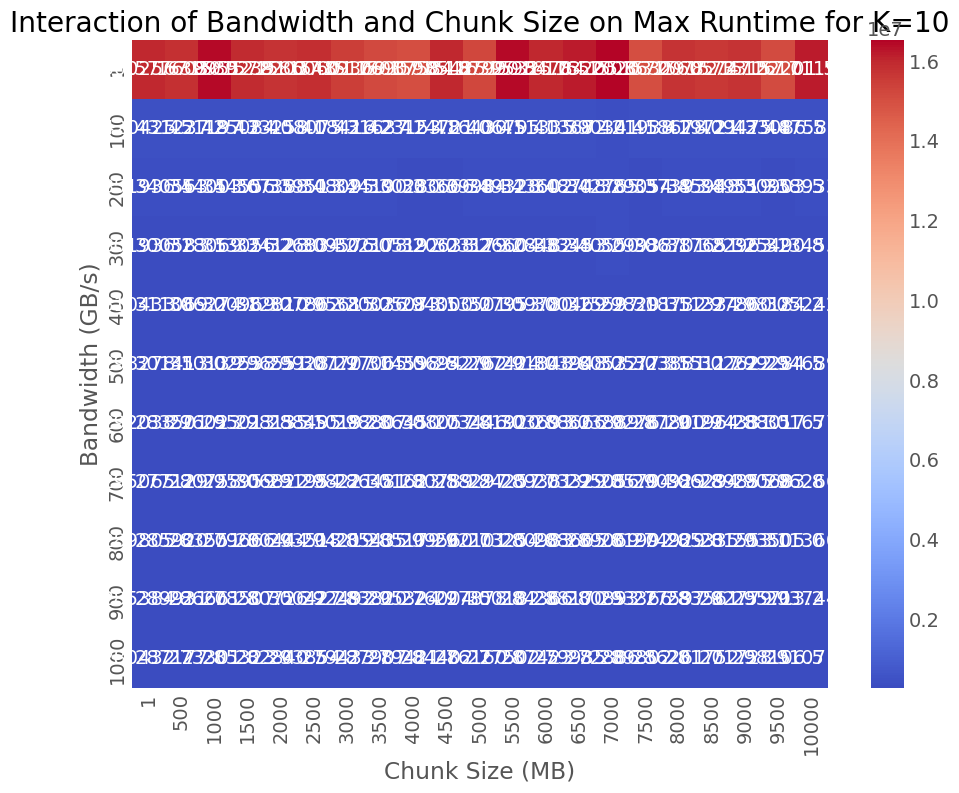

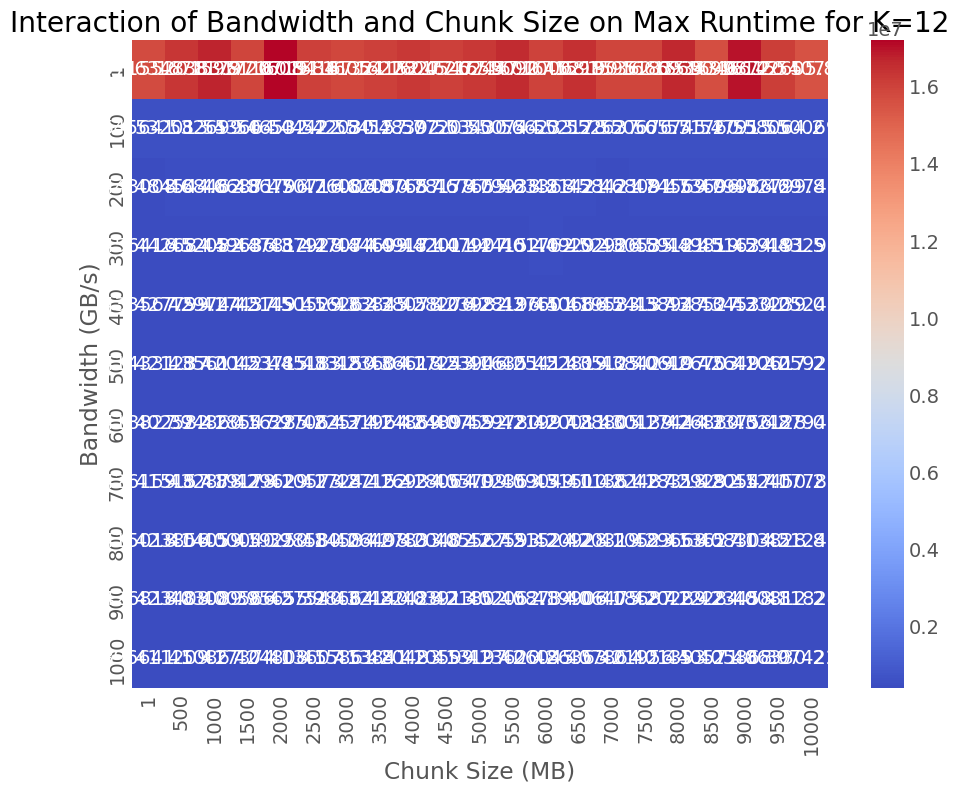

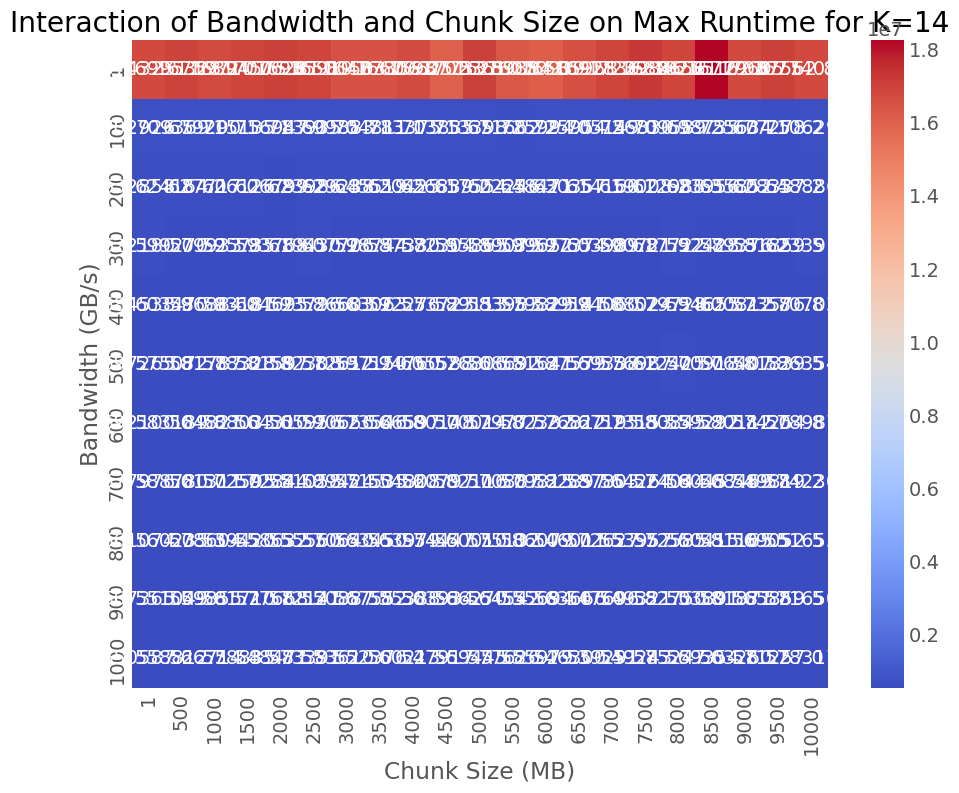

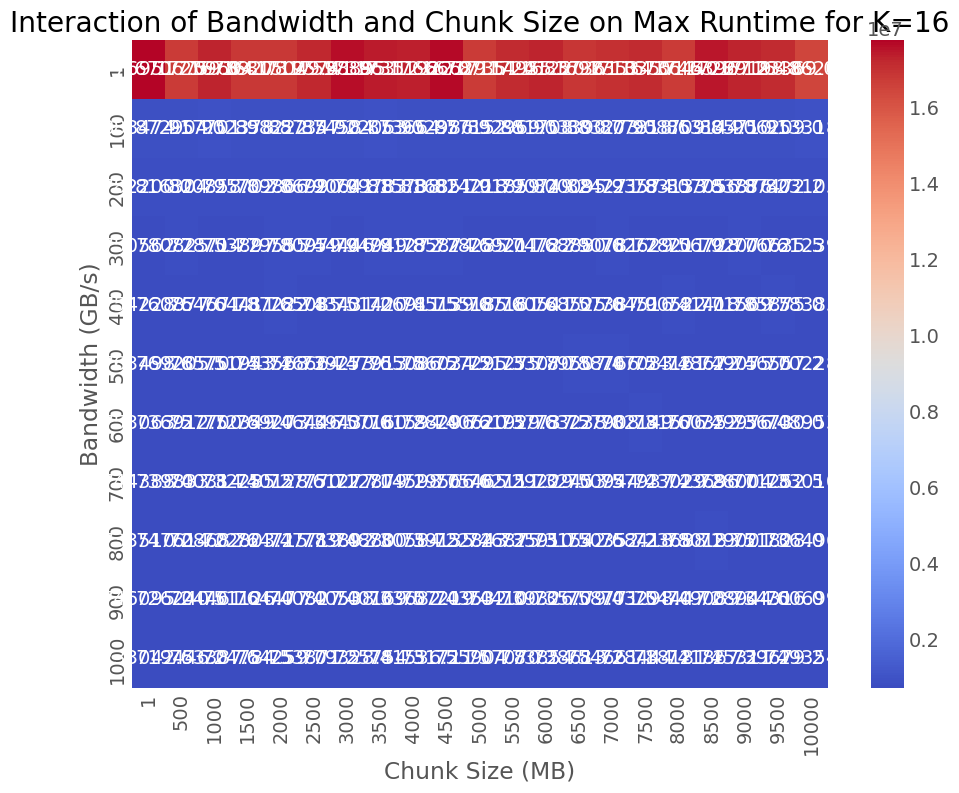

In [97]:
# Interaction effect of bandwidth and chunk size
k_values = sorted(df['K'].unique())
for k in k_values:
    pivot_table = df[df['K'] == k].pivot_table(values='max_runtime', index='bandwidth', columns='chunk_size')
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap='coolwarm')  # Adjusted format code here
    plt.title(f'Interaction of Bandwidth and Chunk Size on Max Runtime for K={k}')
    plt.xlabel('Chunk Size (MB)')
    plt.ylabel('Bandwidth (GB/s)')
    plt.show()



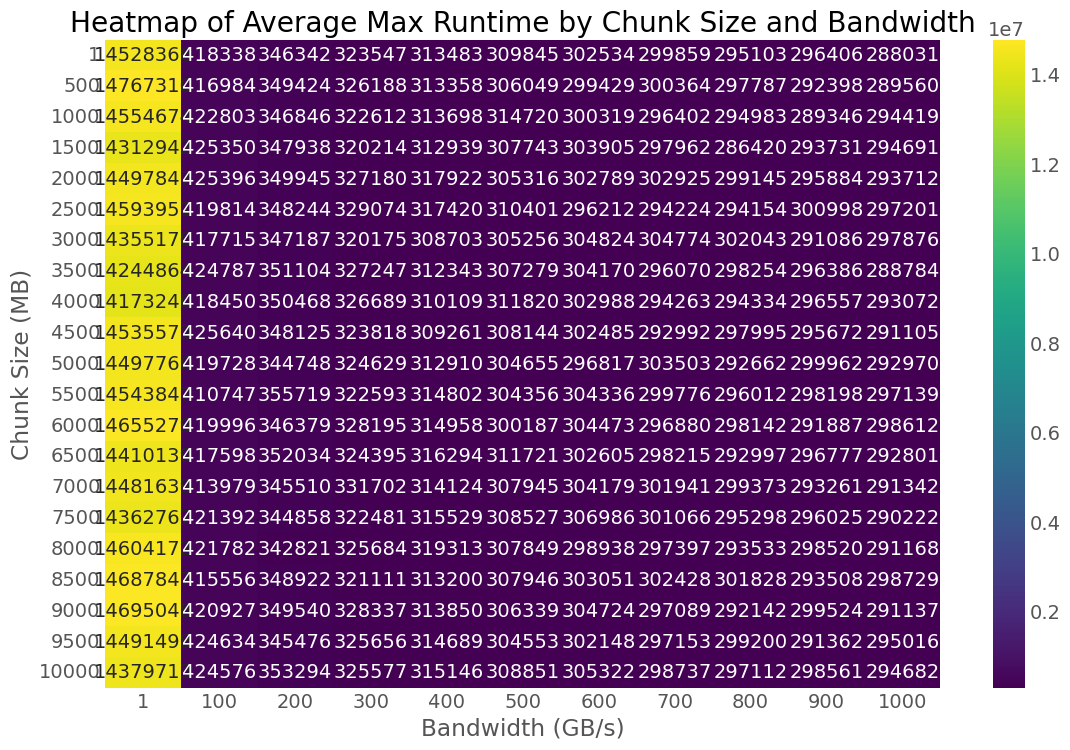

In [100]:
# Heatmap of runtime variation
pivot_table = df.pivot_table(values='max_runtime', index='chunk_size', columns='bandwidth', aggfunc='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap='viridis')
plt.title('Heatmap of Average Max Runtime by Chunk Size and Bandwidth')
plt.xlabel('Bandwidth (GB/s)')
plt.ylabel('Chunk Size (MB)')
plt.show()

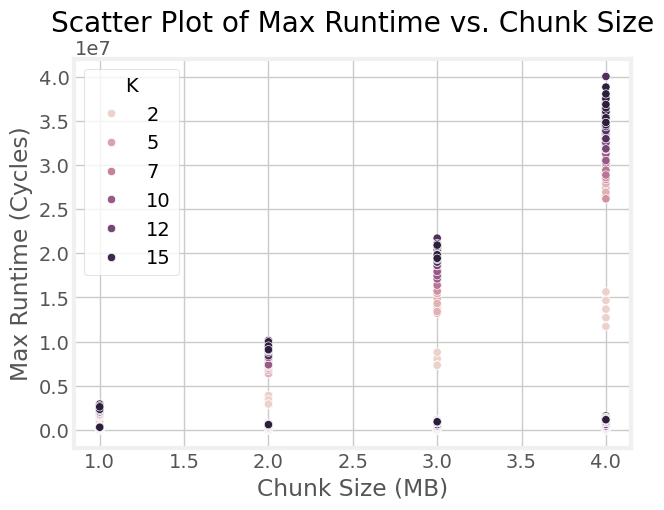

In [103]:
# Scatter plot for runtime versus chunk size
sns.scatterplot(data=df, x='chunks_per_collective', y='max_runtime', hue='K')
plt.title('Scatter Plot of Max Runtime vs. Chunk Size')
plt.xlabel('Chunk Size (MB)')
plt.ylabel('Max Runtime (Cycles)')
plt.legend(title='K')
plt.show()

In [105]:
from scipy.stats import zscore

# Calculate z-scores of max runtimes
df['max_runtime_z'] = zscore(df['max_runtime'])

# Filter outliers
outliers = df[(df['max_runtime_z'] > 3) | (df['max_runtime_z'] < -3)]
print("Identified Outliers:")
print(outliers[['K', 'bandwidth', 'chunk_size', 'chunks_per_collective', 'max_runtime']])


Identified Outliers:
       K  bandwidth  chunk_size  chunks_per_collective  max_runtime
926    4          1           1                      3     18544105
927    4          1           1                      4     30580000
930    4          1         500                      3     20012945
931    4          1         500                      4     30824640
935    4          1        1000                      4     30090720
...   ..        ...         ...                    ...          ...
6543  16          1        9000                      4     36448254
6546  16          1        9500                      3     19827040
6547  16          1        9500                      4     36842204
6550  16          1       10000                      3     19432888
6551  16          1       10000                      4     34809422

[263 rows x 5 columns]


## Statistical Analysis

### ANOVA 

In [112]:
import scipy.stats as stats

# Example: ANOVA for comparing max runtimes across different values of K
groups = []
for k in df['K'].unique():
    groups.append(df[df['K'] == k]['max_runtime'])

f_value, p_value = stats.f_oneway(*groups)
print("ANOVA results: F =", f_value, ", P =", p_value)


ANOVA results: F = 8.522197732943152 , P = 1.9563859418450717e-10


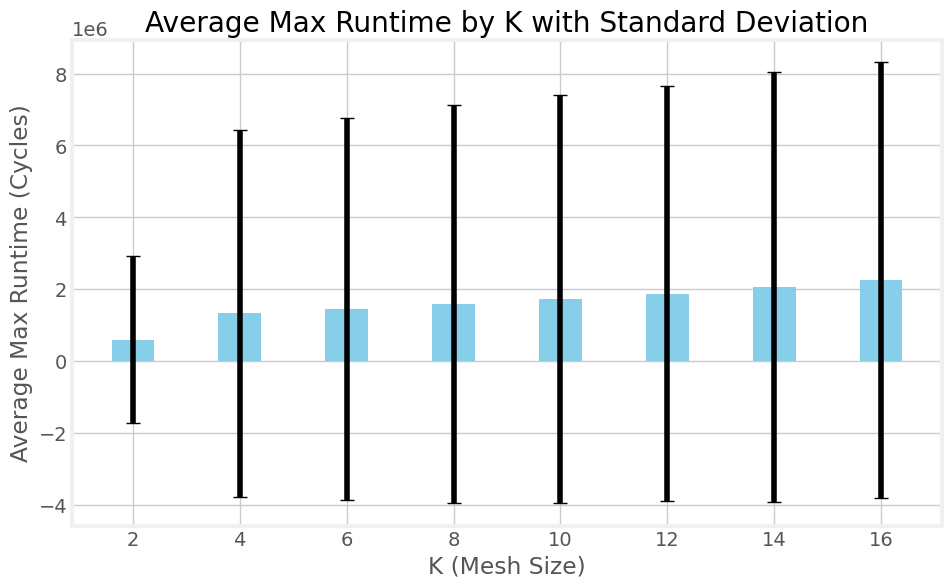

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assume df contains columns for 'K' and 'max_runtime'
means = df.groupby('K')['max_runtime'].mean()
stds = df.groupby('K')['max_runtime'].std()

plt.figure(figsize=(10, 6))
plt.bar(means.index, means, yerr=stds, capsize=5, color='skyblue')
plt.xlabel('K (Mesh Size)')
plt.ylabel('Average Max Runtime (Cycles)')
plt.title('Average Max Runtime by K with Standard Deviation')
plt.show()


In [107]:
# Example: t-Test between two specific K values
runtime_k2 = df[df['K'] == 2]['max_runtime']
runtime_k10 = df[df['K'] == 10]['max_runtime']

t_value, p_value = stats.ttest_ind(runtime_k2, runtime_k10)
print("t-Test results: t =", t_value, ", P =", p_value)


t-Test results: t = -5.555653998847479 , P = 3.1679669551317275e-08


### Correlation Coefficients

In [108]:
correlation_matrix = df[['bandwidth', 'max_runtime']].corr()
print("Correlation matrix:\n", correlation_matrix)


Correlation matrix:
              bandwidth  max_runtime
bandwidth     1.000000    -0.383445
max_runtime  -0.383445     1.000000


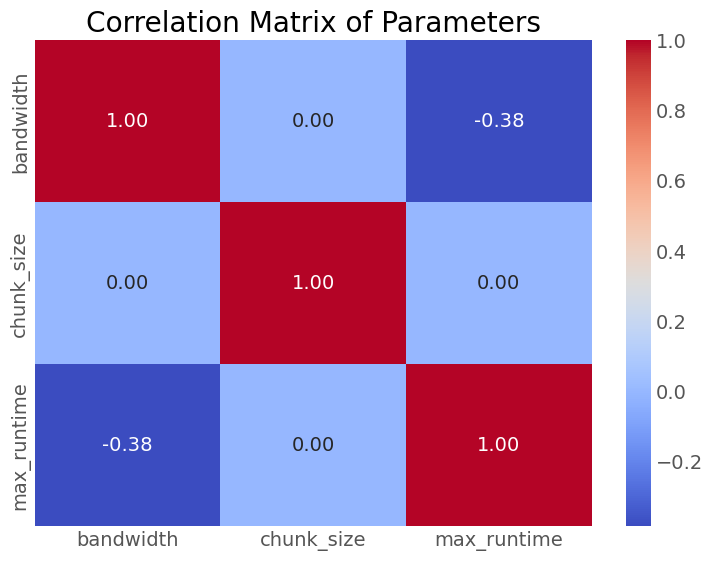

In [114]:
# Assuming df has continuous variables 'bandwidth', 'chunk_size', and 'max_runtime'
correlation_matrix = df[['bandwidth', 'chunk_size', 'max_runtime']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Parameters')
plt.show()


### Regression Analysis

In [110]:
import statsmodels.api as sm

# Preparing data for regression
X = df[['K', 'bandwidth', 'chunk_size']]  # independent variables
X = sm.add_constant(X)  # adding a constant for intercept
y = df['max_runtime']  # dependent variable

# Performing OLS regression
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            max_runtime   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     449.3
Date:                Tue, 30 Apr 2024   Prob (F-statistic):          4.00e-268
Time:                        06:32:34   Log-Likelihood:            -1.2442e+05
No. Observations:                7392   AIC:                         2.488e+05
Df Residuals:                    7388   BIC:                         2.489e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.966e+06   1.82e+05     21.736      0.0

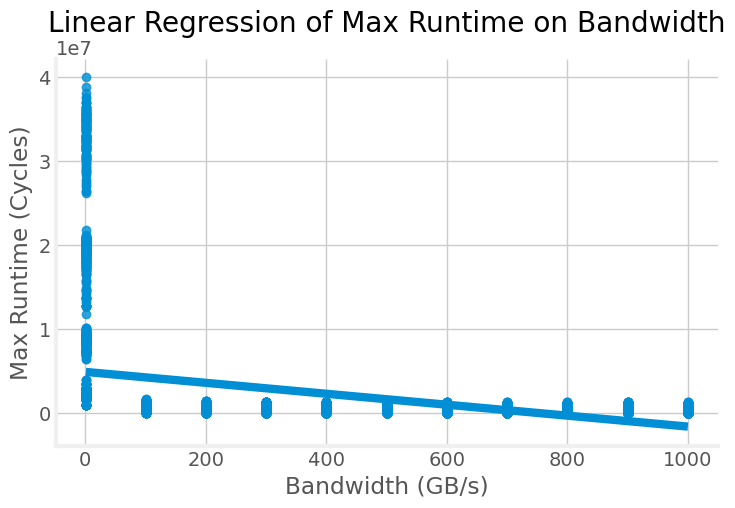

In [115]:
# Using seaborn to plot regression lines
sns.lmplot(x='bandwidth', y='max_runtime', data=df, aspect=1.5)
plt.title('Linear Regression of Max Runtime on Bandwidth')
plt.xlabel('Bandwidth (GB/s)')
plt.ylabel('Max Runtime (Cycles)')
plt.show()


In [ ]:
from lifelines import KaplanMeierFitter

# Assuming df has columns 'duration' and 'event_occurred'
kmf = KaplanMeierFitter()
kmf.fit(df['duration'], event_observed=df['event_occurred'])

kmf.plot_survival_function()
plt.title('Survival Function of GPU Nodes')
plt.xlabel('Time (cycles)')
plt.ylabel('Survival Probability')
plt.show()


## Optimizations

### Pareto Efficiency

In [118]:
# Filter configurations with the lowest mean runtime
optimal_mean = df[df['mean_runtime'] == df['mean_runtime'].min()]

# Display the optimal configurations by mean runtime
print("Optimal configurations by mean runtime:")

optimal_mean


Optimal configurations by mean runtime:


K  link_latency  bandwidth  chunk_size  chunks_per_collective  \
840  2           500       1000           1                      1   
844  2           500       1000         500                      1   
848  2           500       1000        1000                      1   
852  2           500       1000        1500                      1   
856  2           500       1000        2000                      1   
860  2           500       1000        2500                      1   
864  2           500       1000        3000                      1   
868  2           500       1000        3500                      1   
872  2           500       1000        4000                      1   
876  2           500       1000        4500                      1   
880  2           500       1000        5000                      1   
884  2           500       1000        5500                      1   
888  2           500       1000        6000                      1   
892  2           500       1000        6500                      1   
896  2           500       1000        7000                      1   
900  2           500       1000        7500                      1   
904  2           500       1000        8000                      1   
908  2           500       1000        8500                      1   
912  2           500       1000        9000                      1   
916  2           500       1000        9500                      1   
920  2           500       1000       10000                      1   

     max_runtime  mean_runtime  median_runtime  std_dev_runtime  \
840         2976        2976.0          2976.0              0.0   
844         2976        2976.0          2976.0              0.0   
848         2976        2976.0          2976.0              0.0   
852         2976        2976.0          2976.0              0.0   
856         2976        2976.0          2976.0              0.0   
860         2976        2976.0          2976.0              0.0   
864         2976        2976.0          2976.0              0.0   
868         2976        2976.0          2976.0              0.0   
872         2976        2976.0          2976.0              0.0   
876         2976        2976.0          2976.0              0.0   
880         2976        2976.0          2976.0              0.0   
884         2976        2976.0          2976.0              0.0   
888         2976        2976.0          2976.0              0.0   
892         2976        2976.0          2976.0              0.0   
896         2976        2976.0          2976.0              0.0   
900         2976        2976.0          2976.0              0.0   
904         2976        2976.0          2976.0              0.0   
908         2976        2976.0          2976.0              0.0   
912         2976        2976.0          2976.0              0.0   
916         2976        2976.0          2976.0              0.0   
920         2976        2976.0          2976.0              0.0   

     variance_runtime  max_runtime_z  
840               0.0      -0.299016  
844               0.0      -0.299016  
848               0.0      -0.299016  
852               0.0      -0.299016  
856               0.0      -0.299016  
860               0.0      -0.299016  
864               0.0      -0.299016  
868               0.0      -0.299016  
872               0.0      -0.299016  
876               0.0      -0.299016  
880               0.0      -0.299016  
884               0.0      -0.299016  
888               0.0      -0.299016  
892               0.0      -0.299016  
896               0.0      -0.299016  
900               0.0      -0.299016  
904               0.0      -0.299016  
908               0.0      -0.299016  
912               0.0      -0.299016  
916               0.0      -0.299016  
920               0.0      -0.299016

In [120]:
# Adding a composite score that balances mean runtime and variability
df['performance_score'] = df['mean_runtime'] + df['std_dev_runtime']

# Find the configuration with the best score
best_performance = df[df['performance_score'] == df['performance_score'].min()]

print("Best configuration considering runtime and variability:")
best_performance


Best configuration considering runtime and variability:


K  link_latency  bandwidth  chunk_size  chunks_per_collective  \
840  2           500       1000           1                      1   
844  2           500       1000         500                      1   
848  2           500       1000        1000                      1   
852  2           500       1000        1500                      1   
856  2           500       1000        2000                      1   
860  2           500       1000        2500                      1   
864  2           500       1000        3000                      1   
868  2           500       1000        3500                      1   
872  2           500       1000        4000                      1   
876  2           500       1000        4500                      1   
880  2           500       1000        5000                      1   
884  2           500       1000        5500                      1   
888  2           500       1000        6000                      1   
892  2           500       1000        6500                      1   
896  2           500       1000        7000                      1   
900  2           500       1000        7500                      1   
904  2           500       1000        8000                      1   
908  2           500       1000        8500                      1   
912  2           500       1000        9000                      1   
916  2           500       1000        9500                      1   
920  2           500       1000       10000                      1   

     max_runtime  mean_runtime  median_runtime  std_dev_runtime  \
840         2976        2976.0          2976.0              0.0   
844         2976        2976.0          2976.0              0.0   
848         2976        2976.0          2976.0              0.0   
852         2976        2976.0          2976.0              0.0   
856         2976        2976.0          2976.0              0.0   
860         2976        2976.0          2976.0              0.0   
864         2976        2976.0          2976.0              0.0   
868         2976        2976.0          2976.0              0.0   
872         2976        2976.0          2976.0              0.0   
876         2976        2976.0          2976.0              0.0   
880         2976        2976.0          2976.0              0.0   
884         2976        2976.0          2976.0              0.0   
888         2976        2976.0          2976.0              0.0   
892         2976        2976.0          2976.0              0.0   
896         2976        2976.0          2976.0              0.0   
900         2976        2976.0          2976.0              0.0   
904         2976        2976.0          2976.0              0.0   
908         2976        2976.0          2976.0              0.0   
912         2976        2976.0          2976.0              0.0   
916         2976        2976.0          2976.0              0.0   
920         2976        2976.0          2976.0              0.0   

     variance_runtime  max_runtime_z  performance_score  
840               0.0      -0.299016             2976.0  
844               0.0      -0.299016             2976.0  
848               0.0      -0.299016             2976.0  
852               0.0      -0.299016             2976.0  
856               0.0      -0.299016             2976.0  
860               0.0      -0.299016             2976.0  
864               0.0      -0.299016             2976.0  
868               0.0      -0.299016             2976.0  
872               0.0      -0.299016             2976.0  
876               0.0      -0.299016             2976.0  
880               0.0      -0.299016             2976.0  
884               0.0      -0.299016             2976.0  
888               0.0      -0.299016             2976.0  
892               0.0      -0.299016             2976.0  
896               0.0      -0.299016             2976.0  
900               0.0      -0.299016             2976.0  
904

In [122]:
def is_pareto_efficient(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A boolean array to denote Pareto efficiency
    """
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1)  # Keep any point with a lower cost
            is_efficient[i] = True  # And keep self
    return is_efficient

# Apply the Pareto efficiency function
costs = df[['mean_runtime', 'std_dev_runtime']].to_numpy()
pareto_indices = is_pareto_efficient(costs)
pareto_optimal = df[pareto_indices]

print("Pareto optimal configurations:")
print(pareto_optimal)


Pareto optimal configurations:
     K  link_latency  bandwidth  chunk_size  chunks_per_collective  \
840  2           500       1000           1                      1   

     max_runtime  mean_runtime  median_runtime  std_dev_runtime  \
840         2976        2976.0          2976.0              0.0   

     variance_runtime  max_runtime_z  performance_score  
840               0.0      -0.299016             2976.0  


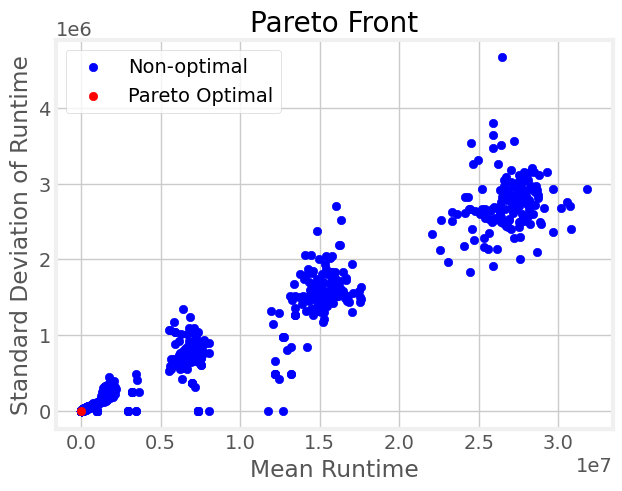

In [124]:
# Plot Pareto front
plt.scatter(df['mean_runtime'], df['std_dev_runtime'], color='blue')
plt.scatter(pareto_optimal['mean_runtime'], pareto_optimal['std_dev_runtime'], color='red')
plt.title('Pareto Front')
plt.xlabel('Mean Runtime')
plt.ylabel('Standard Deviation of Runtime')
plt.legend(['Non-optimal', 'Pareto Optimal'])
plt.show()


### Cluster Analysis

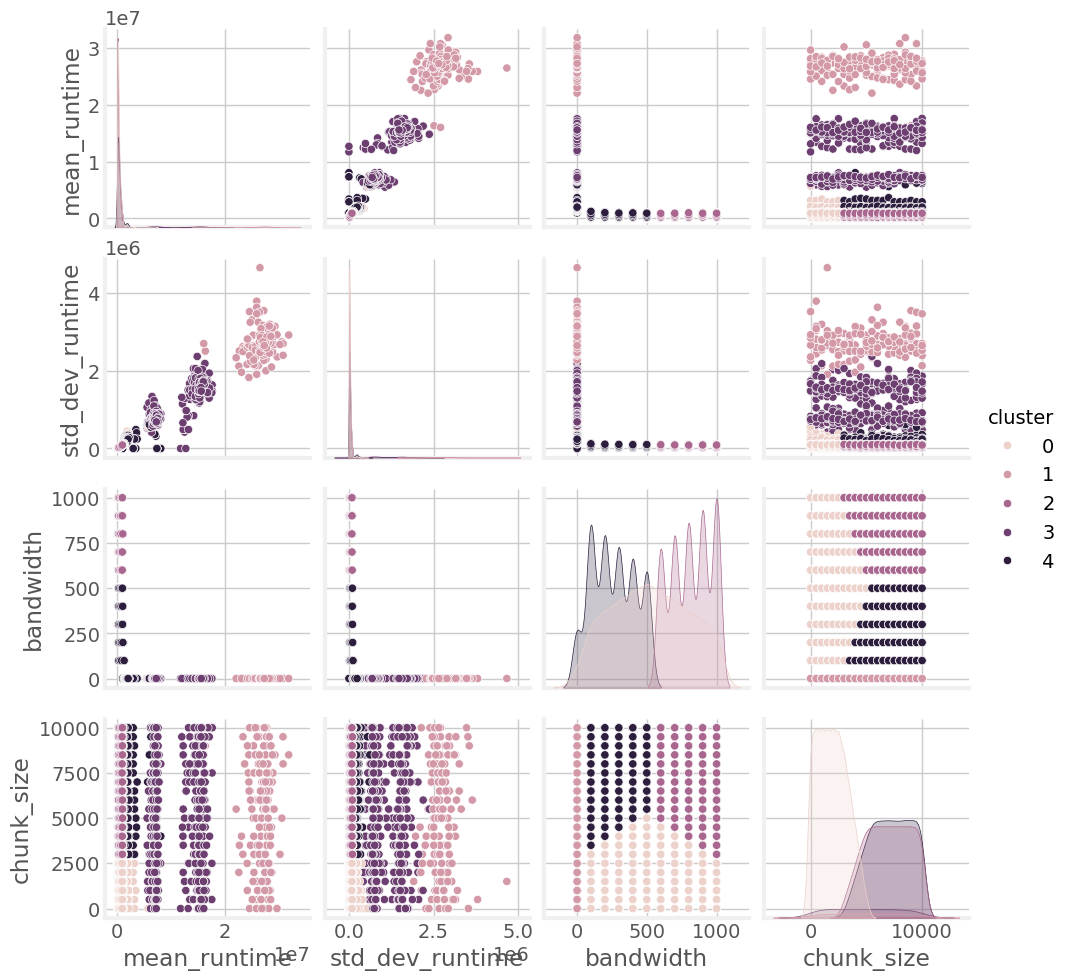

In [130]:
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns

# Assuming df is your DataFrame loaded with the simulation results
df = pd.read_csv('runtime_analysis.csv')

# Select features for clustering (choosing runtime metrics and parameters)
features = df[['mean_runtime', 'std_dev_runtime', 'bandwidth', 'chunk_size']]

# Normalize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=0).fit(features_scaled)
df['cluster'] = kmeans.labels_

# Visualize clusters
sns.pairplot(df, hue='cluster', vars=['mean_runtime', 'std_dev_runtime', 'bandwidth', 'chunk_size'])
plt.show()


### Random Forest

Feature ranking:
1. feature bandwidth (0.5849789915493996)
2. feature chunks_per_collective (0.3723926325659158)
3. feature K (0.04011656262468004)
4. feature chunk_size (0.002511813260004549)


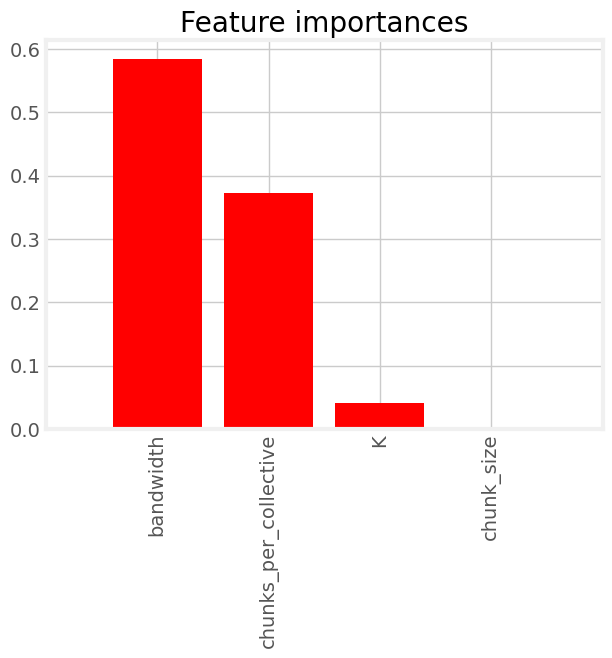

In [131]:
from sklearn.ensemble import RandomForestRegressor

# Prepare data
X = df[['K', 'bandwidth', 'chunk_size', 'chunks_per_collective']]  # Independent variables
y = df['mean_runtime']  # Dependent variable (could also choose max_runtime, etc.)

# Fit Random Forest
forest = RandomForestRegressor(n_estimators=100, random_state=0)
forest.fit(X, y)

# Get feature importance
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. feature {X.columns[indices[f]]} ({importances[indices[f]]})")

# Plot
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()


### Regression Model

In [133]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train a regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")


Mean Squared Error: 15432787547062.525


### HIerachical Clustering

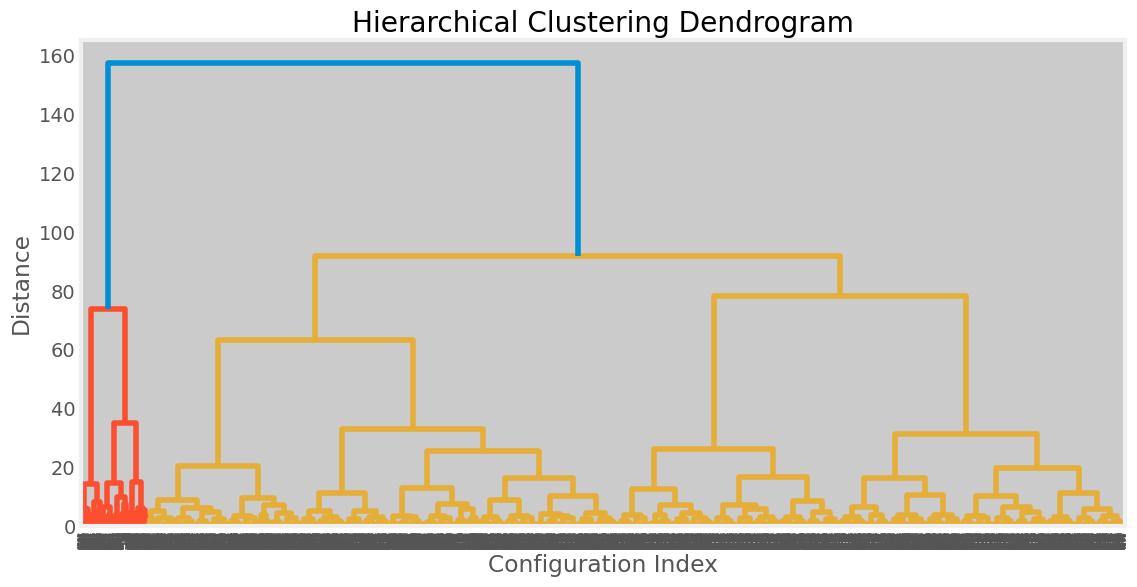

In [136]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Assuming df is your DataFrame loaded with the simulation results
df = pd.read_csv('runtime_analysis.csv')

# Select features for clustering (choosing runtime metrics and parameters)
features = df[['K', 'chunks_per_collective', 'bandwidth', 'chunk_size']]

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Perform hierarchical clustering
# You can choose different linkage methods (e.g., 'ward', 'complete', 'average')
# Adjust the distance metric (e.g., Euclidean, Manhattan) based on your data
clusters = linkage(features_scaled, method='ward', metric='euclidean')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(clusters, labels=df.index, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Configuration Index')
plt.ylabel('Distance')
plt.show()
